# K arms bandits
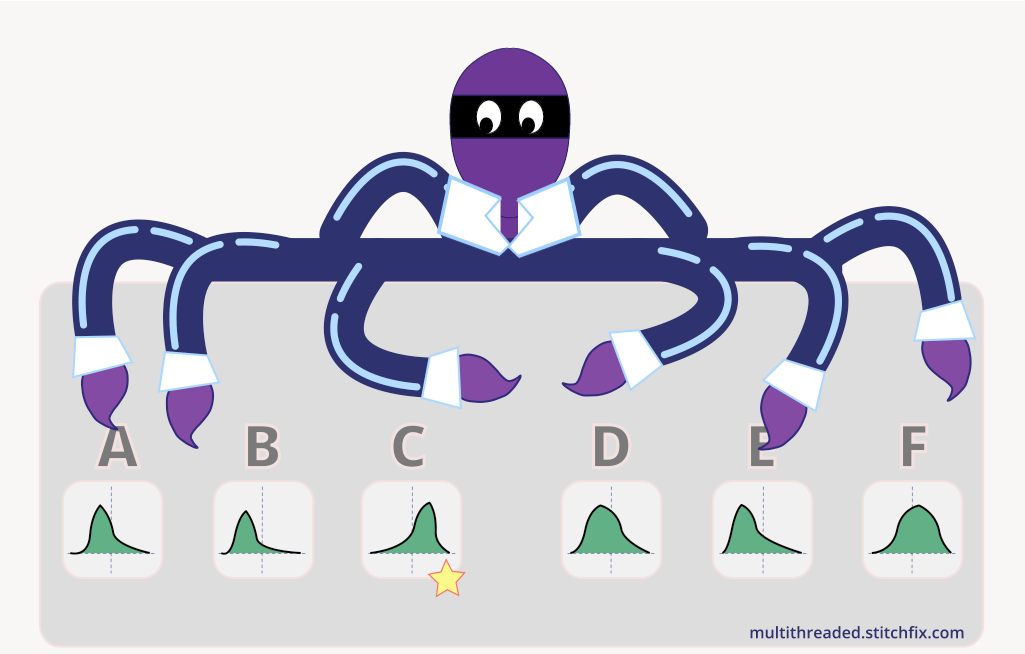

# Overview
The k-armed bandit is a simple model used in reinforcement learning that involves selecting between k different options, or "arms," each of which has an associated reward. The goal is to maximize the total reward obtained over a given number of time steps by selecting the arm with the highest expected reward.

# Advantage
1. Can handle non-stationary environments where the reward distributions may change over time.

# Disadvantage
1. May require a large number of time steps to converge to the optimal strategy, especially if the reward distributions are initially unknown.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns 
import random
sns.set_theme()
np.random.seed(0)

Suppose we have three different cinemas, each featuring a different set of movies. Cinema 0 has movies that average a score of 5 with a standard deviation of 2.5, Cinema 1 has movies that average a score of 8 with a standard deviation of 4, and Cinema 2 has movies that average a score of 10 with a standard deviation of 5. We can use a k-arm bandit algorithm to simulate a scenario in which a moviegoer wants to choose a cinema to visit, but only has time to watch one movie. The algorithm can help us determine which cinema to visit to maximize our movei scores.

In [2]:
cinema_0 = np.random.normal(loc=5,scale=2.5,size=300)
cinema_1 = np.random.normal(loc=8,scale=4,size=300)
cinema_2 = np.random.normal(loc=10,scale=2.5,size=300)

We pick a random cinema for our first trip and check their reward.

In [3]:
slot = [cinema_0, cinema_1, cinema_2]
k = len(slot)
rnd = random.randint(0, k)

print(f"There are {k} cinemas in your neighborhood. \n")

print("--- Rewards for first visit in each cinema---")
print("-----------------------------")
for i, reward in enumerate(slot):
    print(f"Cinema_{i}= {reward[0]}.")
print("")

action = np.random.choice(k)
print(f"Cinema {action} was visited.")
reward = slot[action][0]
print(f"The reward for choosing lever {action} is {reward}.")

There are 3 cinemas in your neighborhood. 

--- Rewards for first visit in each cinema---
-----------------------------
Cinema_0= 9.41013086491916.
Cinema_1= 2.7738925930587337.
Cinema_2= 6.123926637291298.

Cinema 2 was visited.
The reward for choosing lever 2 is 6.123926637291298.


We can also check the distribution of reward of each cinema.

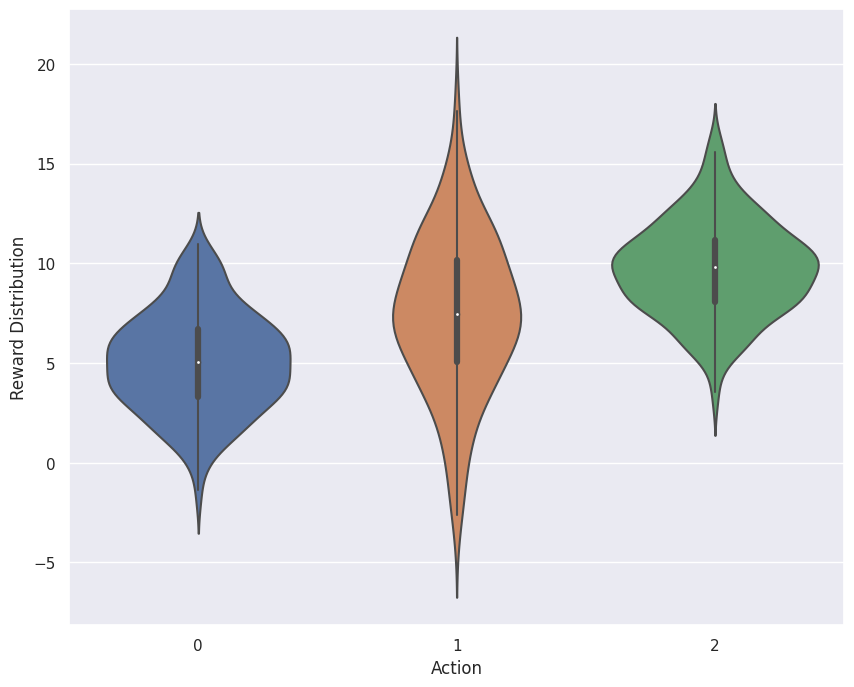

In [4]:
bandits = [] 
rewards = [] 
iterations = 300
for k in range(k):
    for i in range(iterations):
        bandits.append(k)
        reward = slot[k][i]
        rewards.append(reward) 

distributions = pd.DataFrame({"Action" : bandits, "Reward Distribution" : rewards})
plt.figure(figsize = (10, 8))
sns.violinplot(x = "Action", 
               y = "Reward Distribution",
               data = distributions)
plt.show()

As expected, cinema 2 has the highest reward due to its highest mean score of 10. However, we cannot know this based on our first visit to each cinema because, as demonstrated above, our highest score from the first visit is at cinema 0. Therefore, if we rely on this first visit only, we might fall into the trap of only visiting cinema 0 even when the reward is not the highest. This is where the k arms bandit model can help us avoid such a situation.

Now consider the route where we fully explore, i.e no exploit, when we visit each cinema equal times randomly. Let check the reward of a fully explore route.



In [5]:
visit = list(range(300))
random.shuffle(visit)
cinema0_visit = visit[:100]
cinema1_visit = visit[100:200]
cinema2_visit = visit[200:]
reward_step_explore = []
reward_all_explore = 0
for i in cinema0_visit:
    reward_all_explore = reward_all_explore + cinema_0[i]
    reward_step_explore.append(reward_all_explore)
for i in cinema1_visit:
    reward_all_explore = reward_all_explore + cinema_1[i]
    reward_step_explore.append(reward_all_explore)
for i in cinema2_visit:
    reward_all_explore = reward_all_explore + cinema_2[i]
    reward_step_explore.append(reward_all_explore)

Now check the explot only route when we only explore our first visit in each cinema, then choose the cinema with the higest reward (i.e cinema 0) on our first trip with all subsequent visit. We then compare the reward to a all explore route.

In [6]:
reward_step_exploit = []
reward_all_exploit = 0

cinema0_first_visit = cinema_0[0]
cinema1_first_visit = cinema_1[0]
cinema2_first_visit = cinema_2[0]

reward_step_exploit.append(cinema0_first_visit)
reward_step_exploit.append(cinema1_first_visit)
reward_step_exploit.append(cinema2_first_visit)

action, largest_reward = max(enumerate([cinema0_first_visit, cinema1_first_visit, cinema2_first_visit]), key=lambda x: x[1])
print(f"The largest reward is {largest_reward} from cinema {action}.")


The largest reward is 9.41013086491916 from cinema 0.


In [7]:
# Now visit cinema 2 for the rest of iterations
reward_all_exploit = cinema0_first_visit + cinema1_first_visit + cinema2_first_visit
for i in range(3, iterations):
    reward_all_exploit = reward_all_exploit + cinema_0[i]
    reward_step_exploit.append(reward_all_exploit)

# Compare all explore vs all exploit
print(f"The reward for all exploint of {reward_all_exploit} is better than the reward for all explore of {reward_all_explore}.")


The reward for all exploint of 1516.0977626798337 is better than the reward for all explore of 2212.561463976724.


We can visualize the rewards accumulated over every visit for our two models.

[Text(0.5, 0, 'Iterations'), Text(0, 0.5, 'Rewards')]

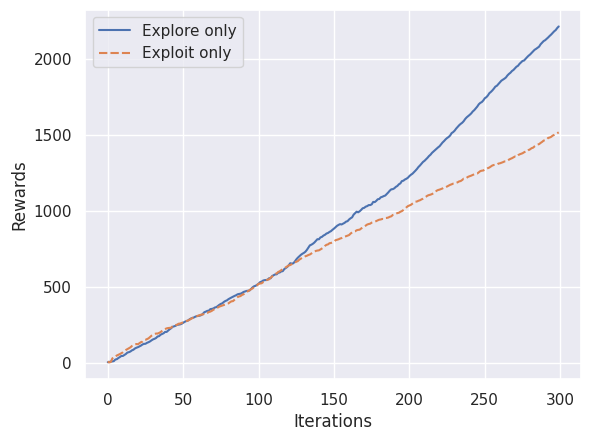

In [12]:
reward_df = pd.DataFrame({'Explore only': reward_step_explore,
                         'Exploit only': reward_step_exploit})
sns.lineplot(data=reward_df[['Explore only', 'Exploit only']]).set( 
                                        xlabel='Iterations', 
                                        ylabel='Rewards')

As shown in the plot above, a strategy of randomly exploring different cinemas can yield better rewards compared to exclusively exploiting one cinema, especially after making multiple visits (after 150 visits). This approach can be especially useful when the initial visit does not provide a fair representation of the rewards for each cinema. For example, in our case, cinema 0 had a higher reward than cinema 2 despite having a lower mean score. Using the k arm bandit algorithm, we can find the optimal balance between exploration and exploitation to maximize the overall reward.

We implement the k arm bandit algorithm which works by:

1. Initialize the expected reward for each arm to zero.
For each time step:
a. Select an arm to play using a strategy, such as the epsilon-greedy strategy, that balances exploration of less known arms and exploitation of the known ones.
b. Receive a reward from the selected arm.
c. Update the expected reward for the selected arm based on the received reward, using a formula such as the sample average method.
2. Repeat steps 21 until the desired number of time steps is reached.

In [9]:
def k_bandit(k, epsilon, slot, iterations = 300):
    rewards = []
    reward = 0
    
    cinema0_first_visit = slot[0][0]
    cinema1_first_visit = slot[1][0]
    cinema2_first_visit = slot[2][0]
    rewards.append(cinema0_first_visit)
    rewards.append(cinema1_first_visit)
    rewards.append(cinema2_first_visit)
    largest_reward, action = max(enumerate([cinema0_first_visit, cinema1_first_visit, cinema2_first_visit]), key=lambda x: x[1])
    
    Q = np.zeros(k)
    Q[0] = cinema0_first_visit
    Q[1] = cinema1_first_visit
    Q[2] = cinema2_first_visit
    k_n = np.zeros(k)

    for i in range(3, iterations):
        # Generate random number
        p = np.random.rand()

        if p < epsilon:
            # Randomly select an action
            action = np.random.choice(k)
        else:
            # Take greedy action which is the cinema that reward the most
            action = np.argmax(Q)

        reward = reward + slot[action][i]
        k_n[action] = k_n[action] + 1
        rewards.append(reward)
        Q[action] = Q[action] + (reward - Q[action]) / k_n[action]  

    return rewards

We can use the k_arm_bandit alogirthm with variations of epsilon where we explore a certain epsilon percentage and exploit the rest.

[Text(0.5, 0, 'Iterations'), Text(0, 0.5, 'Rewards')]

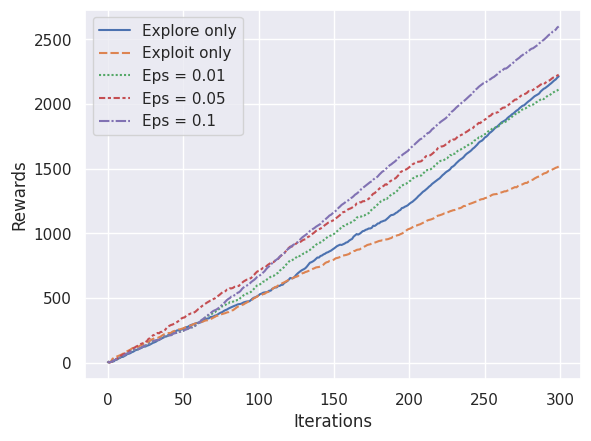

In [11]:
possible_E = [0.01, 0.05, 0.1]
reward_step_eps_0 = k_bandit(3, possible_E[0], slot, iterations = 300)
reward_step_eps_1 = k_bandit(3, possible_E[1], slot, iterations = 300)
reward_step_eps_2 = k_bandit(3, possible_E[2], slot, iterations = 300)

# Compare our eplison models with previous models
reward_df = pd.DataFrame({'Explore only': reward_step_explore,
                         'Exploit only': reward_step_exploit,
                         'Eps = 0.01': reward_step_eps_0,
                         'Eps = 0.05': reward_step_eps_1,
                         'Eps = 0.1': reward_step_eps_2})
sns.lineplot(data=reward_df[['Explore only', 'Exploit only', 'Eps = 0.01','Eps = 0.05', 'Eps = 0.1']]).set( 
                                        xlabel='Iterations', 
                                        ylabel='Rewards')

We can see that an eplison of 0.05 is the optiaml parameter for our algorithm that yields the most reward, where we spend 5% of our cinema visit exploring and explointing the rest 95%. We can also see that an epsilon value of 0.05 has lower rewards compared to epsilon value of 0.1 in the first few visits/iterations but gradually overtaken. 

We can also see how far our model is to the actual total reward possible, which can be measure as regret. Regret can be calculated as total reward possible - total reward gained. Since cinema 2 has the highest reward, the total possible reward is to visit cinema 2 all the time.

<Axes: xlabel='Models', ylabel='Regrets'>

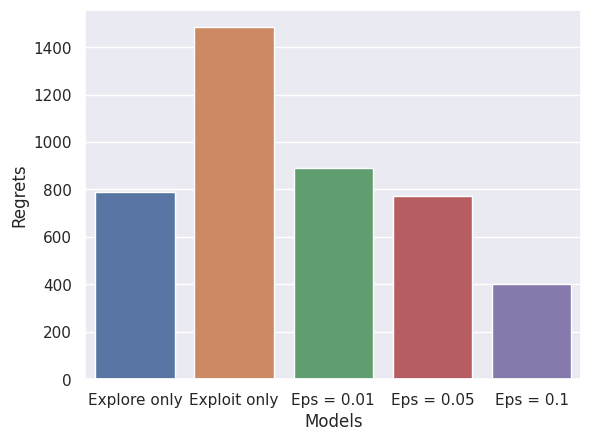

In [13]:
total_reward_possible = 10 * 300
models = ['Explore only', 'Exploit only', 'Eps = 0.01','Eps = 0.05', 'Eps = 0.1']
regrets = np.zeros(len(models))
regrets[0] = total_reward_possible - reward_step_explore[-1]
regrets[1] = total_reward_possible - reward_step_exploit[-1]
regrets[2] = total_reward_possible - reward_step_eps_0[-1]
regrets[3] = total_reward_possible - reward_step_eps_1[-1]
regrets[4] = total_reward_possible - reward_step_eps_2[-1]
regret_df = pd.DataFrame({'Models': models,
                         'Regrets': regrets})
sns.barplot(x = 'Models', y = 'Regrets', data = regret_df)

# Conclusion
As expected, our exploit only route has the highest regrets while eps = 0.05 has the lowest regrets. We can also observe here that choosing the right value of epsilon is important because it affects the balance between exploration and exploitation. If the value of epsilon is too high, the agent may spend too much time exploring and not enough time exploiting, leading to suboptimal rewards. Conversely, if the value of epsilon is too low, the agent may exploit too much and miss out on discovering the best actions, leading to suboptimal rewards in the long run. Therefore, finding the optimal value of epsilon is crucial to maximize the cumulative reward obtained by the agent over time.